# Similarity-Based Movie Recommendation System

This notebook implements a hybrid similarity system to recommend movies.

## Overview

Our system combines **6 different similarity metrics** to find movies similar to a query movie:

1. **Info Similarity** - Based on movie description embeddings
2. **Genre Similarity** - Based on genre overlap (action, drama, etc.)
3. **Year Similarity** - Based on release year proximity
4. **Content Rating Similarity** - Based on age rating (PG, R, etc.)
5. **Review Style Similarity** - Based on how critics write about the movie
6. **Review Type Similarity** - Based on fresh/rotten patterns across critics

## Key Technologies

- **Sentence Transformers** - Converts text to 384-dimensional embeddings
- **Cosine Similarity** - Measures similarity between vectors
- **Hybrid Scoring** - Weighted combination of all metrics

## Process

1. Load and group data by movie
2. Vectorize movie data (convert to numbers)
3. Build similarity matrices
4. Combine into hybrid score
5. Query for similar movies


## Setup: Install Required Libraries

Run this cell first if you don't have these libraries installed.

In [1]:
# Install required libraries (uncomment if needed):
# !pip install numpy pandas scikit-learn matplotlib seaborn sentence-transformers


## Step 1: Import Libraries

In [2]:
import numpy as np
import pandas as pd
import os
import pickle
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Set plotting style
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['figure.dpi'] = 100
sns.set_style("whitegrid")

c:\Users\Brend\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm



## Step 2: Define Global Variables

These are all possible genres and age ratings in our dataset.

**Note:** 'NR' (Not Rated) is excluded from age ratings to create a neutral vector when encoding.

In [3]:
all_genres = [
    'science fiction & fantasy', 'drama', 'western', 'comedy', 'classics',
    'action & adventure', 'kids & family', 'musical & performing arts',
    'documentary', 'art house & international', 'horror', 'sports & fitness',
    'faith & spirituality', 'mystery & suspense', 'animation', 'special interest', 'romance'
]
#no 'nr' to make it a neutral vector if its in the rating
all_age_ratings = ['pg', 'r', 'g', 'pg-13', 'nc17']

## Step 3: Data Loading Functions

In [4]:
def get_dataset() -> pd.DataFrame:

    dataset = '../datasets/final_dataset.csv'

    final_dataset = pd.read_csv(dataset)

    return final_dataset

In [5]:
def group() -> list[dict]:

    final_dataset = get_dataset()
    
    #group movies together
    grouped = final_dataset.groupby('rotten_tomatoes_link')

    movie_data = []

    for movie_id, group in grouped:

        #Critic data
        reviews = group['review_content'].tolist()
        critic_names = group['critic_name'].to_list()
        review_types = group['review_type'].to_list()

        # Get metadata (take first row since they're all the same)
        first_row = group.iloc[0]

        #append dict of each movie
        movie_data.append({
            'movie_id': movie_id,
            'movie_title': first_row['movie_title'],
            'content_rating': first_row['content_rating'],
            'genres': first_row['genres'],
            'year': first_row['original_release_date'],
            'movie_info': first_row['movie_info'], #Movie description/synopsis text

            #Per critic data
            'reviews': reviews,  # List of all review texts
            'critic_names': critic_names,   #List of all critic names
            'review_types': review_types, #List of all review types

        })
        
    #minimum amount of reviews
    min_reviews = 5

    movie_data_filtered = [
        movie for movie in movie_data
        if len(movie['reviews']) >= min_reviews
    ]
    
    print(f"Loaded {len(movie_data_filtered)} movies with ≥{min_reviews} reviews")
    movie_data = movie_data_filtered

    return movie_data

## Step 4: Vectorization Functions

**Goal:** Convert text and categories to numbers that we can compare

**What gets vectorized:**
- Movie descriptions → 384-dimensional embeddings (semantic meaning)
- Genres → Binary vectors (1 if present, 0 if not)
- Content ratings → Binary vectors (1 for the rating, 0 for others)
- Years → Normalized to 0-1 range
- Review texts → Average of all critic review embeddings (writing style)
- Review types → Binary fresh(1)/rotten(0) patterns

In [6]:
#Create embeddings for content and review style
def vectorize(movie_data: list) -> list[dict]:

    #creates binary list of genres 
    def encode_genres(movie_genres:list,all_genres:list):
        return [1 if genre in movie_genres else 0 for genre in all_genres]
    
    #creates binary list of ratings
    def encode_content_rating(content_rating,all_content_ratings):
        return [1 if cr == content_rating else 0 for cr in all_content_ratings]
    
    def encode_review_type(review_types):
        return [1 if rt == "fresh" else 0 for rt in review_types]
       
    print("Initializing sentence transformer...")

    model = SentenceTransformer('all-MiniLM-L6-v2')

    #normalize year range
    year = [movie['year'] for movie in movie_data if movie['year'] > 0]
    min_year = min(year)
    max_year = max(year)

    total_movies = len(movie_data)

    for i, movie in enumerate(movie_data, start=1):

        # Print progress
        print(f"Processing movie {i}/{total_movies} ({i/total_movies*100:.1f}%) - {movie['movie_title']}")

        # Encode all movie infos for this movie
        movie['movie_info_embeddings'] = model.encode(movie['movie_info'])

        #Content rating
        movie['content_rating_norm'] = encode_content_rating(movie['content_rating'],all_age_ratings)

        #Genres
        movie['genre_vector'] = encode_genres(movie['genres'], all_genres)

        #Year
        movie['year_norm'] = (movie['year'] - min_year) / (max_year - min_year)

        # Encode all reviews for this movie
        review_embeddings = model.encode(movie['reviews'])# Shape: (num_reviews, 384)
        #Average to get single movie embedding
        movie['avg_review_embeddings'] = review_embeddings.mean(axis=0)

        #review type
        movie['review_types_norm'] = encode_review_type(movie['review_types'])
       
    vectorized_movie_data = movie_data

    return vectorized_movie_data

Checks if vectorized movie data pickle exists. If not, generate, save, and return it

**Caching:** Results saved to `../cache/vectorized_movie_data.pkl` so we don't recompute (takes ~10-20 minutes first time)

In [7]:
def load_or_create_vectorized_data(pickle_path="../cache/vectorized_movie_data.pkl") -> list[dict]:
    if os.path.exists(pickle_path):
        print(f"Loading vectorized movie data from {pickle_path}...")
        with open(pickle_path, "rb") as f:
            vectorized_movie_data = pickle.load(f)
    else:
        print("Pickle file not found. Generating vectorized movie data...")
        grouped = group()
        vectorized_movie_data = vectorize(grouped)
        with open(pickle_path, "wb") as f:
            pickle.dump(vectorized_movie_data, f)
        print(f"Vectorized movie data saved to {pickle_path}.")
    return vectorized_movie_data


## Step 5: Similarity Matrix Functions

**Goal:** Create 6 separate similarity matrices, each capturing a different aspect

Each function:
1. Stacks all movie vectors into a matrix (one row per movie)
2. Computes pairwise cosine similarity
3. Returns matrix where `matrix[i][j]` = similarity between movie i and movie j

**Similarity matrices:**

1. **Info** - Based on movie description embeddings (semantic meaning)
2. **Genre** - Based on genre overlap (how many genres they share)
3. **Year** - Based on release year proximity (1999 vs 2000 = very similar)
4. **Content Rating** - Based on age rating match (both R-rated = similar)
5. **Style** - Based on review writing style (how critics describe them)
6. **Type** - Based on fresh/rotten patterns across critics (correlation of ratings)

**Cosine Similarity:** Ranges 0-1 where:
- 1.0 = identical
- 0.5 = somewhat similar
- 0.0 = completely different

**Caching:** All matrices saved to `../cache/similarity_matrices.pkl`

In [8]:
def build_info_sim(vectorized_movie_data) -> np.ndarray:

    info_vectors = np.vstack([movie['movie_info_embeddings'] for movie in vectorized_movie_data])

    #pairwise cosine similarity
    info_sim = cosine_similarity(info_vectors).astype('float32')

    print(f"Info similarity matrix: {info_sim.shape}")

    return info_sim


def build_content_rating_sim(vectorized_movie_data) -> np.ndarray:

    content_rating_vectors = np.vstack([movie['content_rating_norm'] for movie in vectorized_movie_data])

    #pairwise cosine similarity
    content_rating_sim = cosine_similarity(content_rating_vectors).astype('float32')

    print(f"Content rating similarity matrix: {content_rating_sim.shape}")

    return content_rating_sim

def build_genre_sim(vectorized_movie_data) -> np.ndarray:

    genre_vectors = np.vstack([movie['genre_vector'] for movie in vectorized_movie_data])

    #pairwise cosine similarity
    genre_sim = cosine_similarity(genre_vectors).astype('float32')

    print(f"Genre similarity matrix: {genre_sim.shape}")

    return genre_sim

def build_year_sim(vectorized_movie_data) -> np.ndarray:

    year_vectors = np.vstack([movie['year_norm'] for movie in vectorized_movie_data])

    #pairwise cosine similarity
    year_sim = cosine_similarity(year_vectors).astype('float32')

    print(f"Year similarity matrix: {year_sim.shape}")

    return year_sim

#content
def build_content_sim(vectorized_movie_data) -> np.ndarray:

    content_vectors = np.vstack([movie['content_vector'] for movie in vectorized_movie_data])

    #pairwise cosine similarity
    content_sim = cosine_similarity(content_vectors).astype('float32')

    print(f"Content similarity matrix: {content_sim.shape}")

    return content_sim
    
#style
def build_review_style_sim(vectorized_movie_data) -> np.ndarray:
    
    review_embeddings = np.vstack([movie['avg_review_embeddings'] for movie in vectorized_movie_data])

    #pairwise cosine similarity
    review_sim = cosine_similarity(review_embeddings).astype('float32')

    print(f"Review similarity matrix: {review_sim.shape}")

    return review_sim

def build_review_type_sim(vectorized_movie_data) -> np.ndarray:

    #Get all critics
    all_critics = set()
    for movie in vectorized_movie_data:
        all_critics.update(movie['critic_names'])
    all_critics = sorted(all_critics)

    #Get all movie titles
    all_movies = [movie['movie_title'] for movie in vectorized_movie_data]
    
    #create Movie x Critic matrix
    matrix = pd.DataFrame(np.nan, index = all_movies, columns=all_critics)

    #Fill in review scores
    for movie in vectorized_movie_data:

        mit = movie['movie_title']

        for critic,review_type in zip(movie['critic_names'], movie['review_types_norm']):
            matrix.loc[mit,critic] = review_type

    #Pearson correlation movie x movie (1 to -1)
    type_sim = matrix.T.corr(method='pearson')

    # normalize to 0-1
    type_sim = (type_sim + 1) / 2

    #convert to np array
    type_sim_array = type_sim.values

    #fill empty pairs with 0.5(neutral)
    type_sim = np.nan_to_num(type_sim_array, nan=0.5)

    print(f"Type similarity matrix: {type_sim.shape}")

    return type_sim

Checks if similarity matrices pickle exists. If not, generate, save, and return it

In [9]:
def load_or_create_similarity_matrices(vectorized_data, pickle_path="../cache/similarity_matrices.pkl"):
    """Load or compute all similarity matrices"""
    
    if os.path.exists(pickle_path):
        print(f"Loading similarity matrices from {pickle_path}...")
        with open(pickle_path, "rb") as f:
            matrices = pickle.load(f)
        info_sim = matrices['info']
        content_rating_sim = matrices['content_rating']
        genre_sim = matrices['genre']
        year_sim = matrices['year']
        style_sim = matrices['style']
        type_sim = matrices['type']
    else:
        print("Pickle file not found. Computing similarity matrices...")
        info_sim = build_info_sim(vectorized_data)
        content_rating_sim = build_content_rating_sim(vectorized_data)
        genre_sim = build_genre_sim(vectorized_data)
        year_sim = build_year_sim(vectorized_data)
        style_sim = build_review_style_sim(vectorized_data)
        type_sim = build_review_type_sim(vectorized_data)
        
        print(f"Saving similarity matrices to {pickle_path}...")
        with open(pickle_path, "wb") as f:
            pickle.dump({
                'info': info_sim,
                'content_rating': content_rating_sim,
                'genre': genre_sim,
                'year': year_sim,
                'style': style_sim,
                'type': type_sim
            }, f)
    
    return info_sim, content_rating_sim, genre_sim, year_sim, style_sim, type_sim

## Step 6: Hybrid Scoring

**Goal:** Combine all 6 similarity matrices into one final score

**Method:** Weighted sum
- Each similarity matrix gets a weight (Î±, Î², Î³, Î´, Îµ, Î¶)
- Final similarity = weighted average of all 6 scores

**Current weights:**
- Î± (alpha) = 0.2 â†’ Info similarity (movie description)
- Î² (beta) = 0.2 â†’ Content rating similarity
- Î³ (gamma) = 0.2 â†’ Genre similarity
- Î´ (delta) = 0.2 â†’ Year similarity
- Îµ (epsilon) = 0.1 â†’ Review style similarity
- Î¶ (zeta) = 0.1 â†’ Review type similarity

**Total = 1.0** (weights must sum to 1)

**You can experiment with different weights!** For example:
- Emphasize genre: `gamma = 0.4`
- Ignore year: `delta = 0.0`

In [10]:
def hybrid_score(info_sim, content_rating_sim, genre_sim, year_sim, style_sim, type_sim, alpha, beta, gamma, delta, epsilon, zeta):
    
    hybrid_sim = (alpha * info_sim) + (beta * content_rating_sim) + (gamma * genre_sim) + (delta * year_sim) + (epsilon * style_sim) + (zeta * type_sim)

    return hybrid_sim

## Step 7: Load All Data and Compute Similarities

1. **Load vectorized data** (or create if first time)
   - If cached: loads in ~10 seconds
   - If not cached: takes ~10-30 minutes to compute

2. **Load similarity matrices** (or create if first time)
   - If cached: loads in ~5 seconds
   - If not cached: takes ~2-5 minutes to compute

**After this runs, the system is ready to query!**

In [11]:
# Load or create vectorized data
vectorized_data = load_or_create_vectorized_data('../cache/vectorized_movie_data.pkl')

# Load or create similarity matrices  
info_sim, content_rating_sim, genre_sim, year_sim, style_sim, type_sim = load_or_create_similarity_matrices(
    vectorized_data, 
    '../cache/similarity_matrices.pkl'
)

weights  = (0.2, 0.2, 0.2, 0.2, 0.1, 0.1)

print("System ready")

Loading vectorized movie data from ../cache/vectorized_movie_data.pkl...
Loading similarity matrices from ../cache/similarity_matrices.pkl...
System ready


## Step 8: Query Function

**Goal:** Find movies most similar to a query movie

**Process:**
1. Find the query movie in our dataset (by exact title match)
2. Compute hybrid similarity for one movie (compute only one row of the full matrix - this is much faster!)
3. Sort all movies by similarity score (highest first)
4. Return top k movies (excluding the query itself)

**Parameters:**
- `movie_title` - Name of movie to find similar to (exact match required)
- `k` - Number of recommendations to return (default 10)

**Output:** Prints a formatted table of recommendations with scores

In [12]:
def query_movie(movie_title,vectorized_movie_data=vectorized_data,k=10):

    #Find iterable of query movie
    query_id = None
    for i,movie in enumerate(vectorized_movie_data):
        if movie['movie_title'] == movie_title:
            query_id = i
            break
    if query_id is None:
        print(f"Movie '{movie_title}' not found!")
        return []
   
    # Compute hybrid score ONLY for this movie (1Ã—N instead of NÃ—N)
    hybrid_row = (
        weights[0] * info_sim[query_id] +
        weights[1] * content_rating_sim[query_id] +
        weights[2] * genre_sim[query_id] +
        weights[3] * year_sim[query_id] +
        weights[4] * style_sim[query_id] +
        weights[5] * type_sim[query_id]
    )


   
    # Sort and get top-k (excluding itself)
    sorted_indices = np.argsort(hybrid_row)[::-1]

    recommendations = []

    for pos in sorted_indices[1:k+1]: # skip the movie itself (index 0 in sorted list)
        recommendations.append((vectorized_movie_data[pos]['movie_title'], hybrid_row[pos]))

    ################################
    max_len = max(len(movie) for movie, _ in recommendations)
    print()
    print(f"Query movie: {movie_title}")
    print()
    print("MOVIE".ljust(max_len)  +  "  SCORE")

    for m,s in recommendations:
        score = round(s,2)
        print(f'{m:{max_len}}  {score}')
    
    return recommendations


## Step 9: Query for Similar Movies!

Change `"aliens"` to any movie title in the dataset (must match exact title).

In [13]:
# Query Example

query_movie("aliens", k=10);


Query movie: aliens

MOVIE                                 SCORE
alien3                                0.83
lifeforce                             0.82
virus                                 0.82
alien resurrection                    0.81
contamination                         0.8
underworld: awakening                 0.8
doom                                  0.8
pandorum                              0.8
aliens vs. predator: requiem (avp 2)  0.8
deepstar six                          0.8


## Step 10: Visualizations

These visualizations demonstrate that:
- Each similarity component captures different movie relationships
- Weight configurations significantly affect recommendations
- The hybrid approach combines multiple perspectives for better results

In [14]:
def plot_component_contributions(query_title, vectorized_data, 
                                  info_sim, content_rating_sim, genre_sim, 
                                  year_sim, style_sim, type_sim,
                                  weights=(0.2, 0.2, 0.2, 0.2, 0.1, 0.1), 
                                  top_k=5):
    # Unpack weights
    alpha, beta, gamma, delta, epsilon, zeta = weights
    
    # Find query movie index
    query_idx = None
    for i, movie in enumerate(vectorized_data):
        if movie['movie_title'].lower() == query_title.lower():
            query_idx = i
            break
    
    if query_idx is None:
        print(f"Movie '{query_title}' not found.")
        return
    
    # Calculate hybrid scores
    hybrid_sim = (alpha * info_sim + beta * content_rating_sim + 
                  gamma * genre_sim + delta * year_sim + 
                  epsilon * style_sim + zeta * type_sim)
    
    # Get top-k recommendations
    sim_scores = hybrid_sim[query_idx]
    sorted_indices = np.argsort(sim_scores)[::-1]
    top_indices = [idx for idx in sorted_indices if idx != query_idx][:top_k]
    
    # Get individual component contributions for each recommendation
    movie_titles = []
    info_contrib = []
    rating_contrib = []
    genre_contrib = []
    year_contrib = []
    style_contrib = []
    type_contrib = []
    
    for idx in top_indices:
        movie_titles.append(vectorized_data[idx]['movie_title'][:25])
        info_contrib.append(alpha * info_sim[query_idx, idx])
        rating_contrib.append(beta * content_rating_sim[query_idx, idx])
        genre_contrib.append(gamma * genre_sim[query_idx, idx])
        year_contrib.append(delta * year_sim[query_idx, idx])
        style_contrib.append(epsilon * style_sim[query_idx, idx])
        type_contrib.append(zeta * type_sim[query_idx, idx])
    
    # Create stacked bar chart
    fig, ax = plt.subplots(figsize=(12, 6))
    
    x = np.arange(len(movie_titles))
    width = 0.6
    
    # Stack the bars
    bars1 = ax.bar(x, info_contrib, width, label=f'Info Embedding (Î±={alpha})', color='#2ecc71')
    bars2 = ax.bar(x, rating_contrib, width, bottom=info_contrib, 
                   label=f'Content Rating (Î²={beta})', color='#3498db')
    bars3 = ax.bar(x, genre_contrib, width, 
                   bottom=np.array(info_contrib) + np.array(rating_contrib),
                   label=f'Genre (Î³={gamma})', color='#9b59b6')
    bars4 = ax.bar(x, year_contrib, width,
                   bottom=np.array(info_contrib) + np.array(rating_contrib) + np.array(genre_contrib),
                   label=f'Year (Î´={delta})', color='#f39c12')
    bars5 = ax.bar(x, style_contrib, width,
                   bottom=np.array(info_contrib) + np.array(rating_contrib) + np.array(genre_contrib) + np.array(year_contrib),
                   label=f'Review Style (Îµ={epsilon})', color='#e74c3c')
    bars6 = ax.bar(x, type_contrib, width,
                   bottom=np.array(info_contrib) + np.array(rating_contrib) + np.array(genre_contrib) + np.array(year_contrib) + np.array(style_contrib),
                   label=f'Review Type (Î¶={zeta})', color='#1abc9c')
    
    # Add total score labels on top
    totals = [sum(x) for x in zip(info_contrib, rating_contrib, genre_contrib, 
                                   year_contrib, style_contrib, type_contrib)]
    for i, total in enumerate(totals):
        ax.text(i, total + 0.01, f'{total:.3f}', ha='center', va='bottom', fontsize=9, fontweight='bold')
    
    ax.set_xlabel('Recommended Movies', fontsize=11)
    ax.set_ylabel('Weighted Similarity Contribution', fontsize=11)
    ax.set_title(f'Hybrid Score Component Breakdown\nQuery: "{query_title}"', fontsize=13, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(movie_titles, rotation=45, ha='right', fontsize=9)
    ax.legend(loc='upper right', fontsize=8)
    ax.set_ylim(0, max(totals) * 1.15)
    
    plt.tight_layout()
    plt.show()
    
    # Print numerical breakdown
    print(f"\n{'='*80}")
    print(f"Component Contribution Analysis for Query: {query_title}")
    print(f"{'='*80}")
    print(f"{'Movie':<28} {'Info':>8} {'Rating':>8} {'Genre':>8} {'Year':>8} {'Style':>8} {'Type':>8} {'TOTAL':>8}")
    print(f"{'-'*80}")
    for i, title in enumerate(movie_titles):
        print(f"{title:<28} {info_contrib[i]:>8.4f} {rating_contrib[i]:>8.4f} {genre_contrib[i]:>8.4f} "
              f"{year_contrib[i]:>8.4f} {style_contrib[i]:>8.4f} {type_contrib[i]:>8.4f} {totals[i]:>8.4f}")

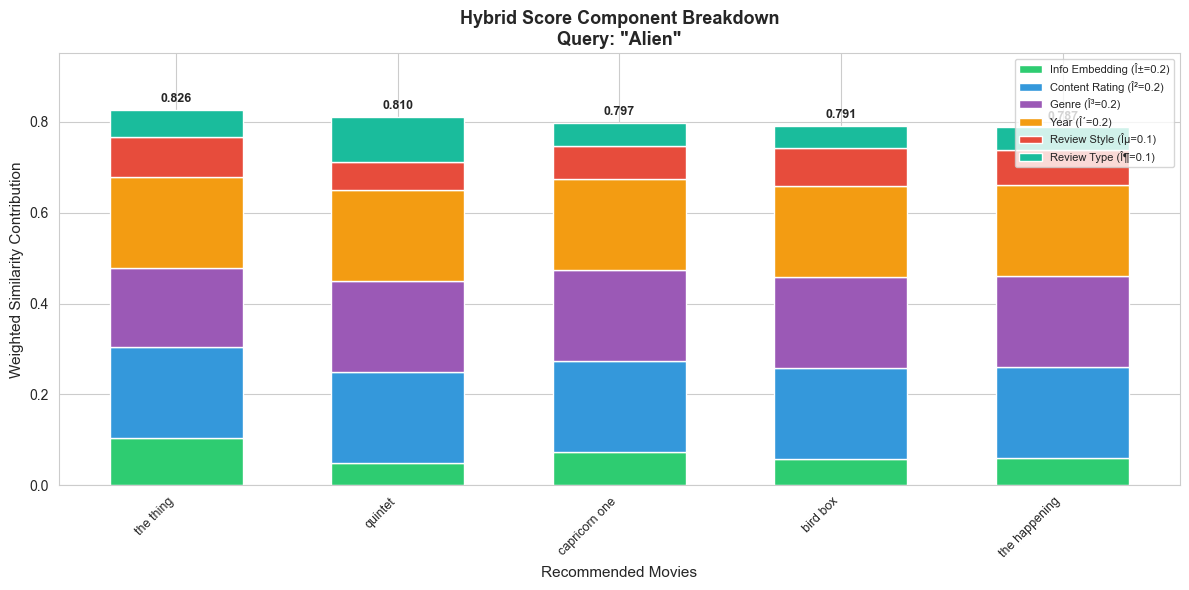


Component Contribution Analysis for Query: Alien
Movie                            Info   Rating    Genre     Year    Style     Type    TOTAL
--------------------------------------------------------------------------------
the thing                      0.1045   0.2000   0.1732   0.2000   0.0878   0.0610   0.8264
quintet                        0.0485   0.2000   0.2000   0.2000   0.0619   0.1000   0.8104
capricorn one                  0.0730   0.2000   0.2000   0.2000   0.0743   0.0500   0.7973
bird box                       0.0591   0.2000   0.2000   0.2000   0.0817   0.0500   0.7908
the happening                  0.0609   0.2000   0.2000   0.2000   0.0763   0.0500   0.7872


In [15]:
plot_component_contributions(
    query_title="Alien",
    vectorized_data=vectorized_data,
    info_sim=info_sim,
    content_rating_sim=content_rating_sim,
    genre_sim=genre_sim,
    year_sim=year_sim,
    style_sim=style_sim,
    type_sim=type_sim,
    weights=(0.2, 0.2, 0.2, 0.2, 0.1, 0.1),
    top_k=5
)

In [16]:
def plot_similarity_distributions(info_sim, content_rating_sim, genre_sim, 
                                   year_sim, style_sim, type_sim):
    """
    Box plots comparing the distribution of similarity values across all
    movie pairs for each similarity component.
    """
    # Sample upper triangle values (excluding diagonal) to avoid self-similarity
    n = info_sim.shape[0]
    upper_indices = np.triu_indices(n, k=1)
    
    # Extract values
    data = {
        'Info\nEmbedding': info_sim[upper_indices],
        'Content\nRating': content_rating_sim[upper_indices],
        'Genre': genre_sim[upper_indices],
        'Year': year_sim[upper_indices],
        'Review\nStyle': style_sim[upper_indices],
        'Review\nType': type_sim[upper_indices]
    }
    
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Create box plots
    bp = ax.boxplot(data.values(), labels=data.keys(), patch_artist=True)
    
    # Color the boxes
    colors = ['#2ecc71', '#3498db', '#9b59b6', '#f39c12', '#e74c3c', '#1abc9c']
    for patch, color in zip(bp['boxes'], colors):
        patch.set_facecolor(color)
        patch.set_alpha(0.7)
    
    ax.set_ylabel('Similarity Value', fontsize=11)
    ax.set_xlabel('Similarity Component', fontsize=11)
    ax.set_title('Distribution of Similarity Values by Component\n(All Movie Pairs)', 
                 fontsize=13, fontweight='bold')
    ax.grid(axis='y', alpha=0.3)
    
    # Add mean markers
    means = [np.mean(v) for v in data.values()]
    ax.scatter(range(1, 7), means, marker='D', color='black', s=50, zorder=3, label='Mean')
    ax.legend(loc='upper right')
    
    plt.tight_layout()
    plt.show()
    
    # Print statistics
    print(f"\n{'='*80}")
    print("Similarity Matrix Statistics")
    print(f"{'='*80}")
    print(f"{'Component':<20} {'Mean':>12} {'Std':>12} {'Min':>12} {'Max':>12} {'Median':>12}")
    print(f"{'-'*80}")
    for name, values in data.items():
        name_clean = name.replace('\n', ' ')
        print(f"{name_clean:<20} {np.mean(values):>12.4f} {np.std(values):>12.4f} "
              f"{np.min(values):>12.4f} {np.max(values):>12.4f} {np.median(values):>12.4f}")

C:\Users\Brend\AppData\Local\Temp\ipykernel_9044\946059035.py:24: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(data.values(), labels=data.keys(), patch_artist=True)


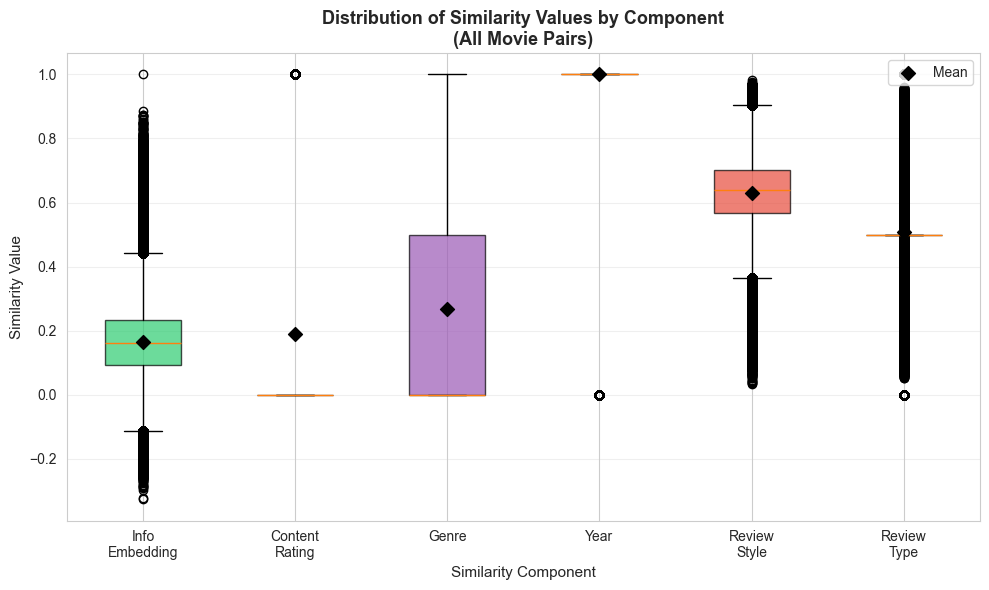


Similarity Matrix Statistics
Component                    Mean          Std          Min          Max       Median
--------------------------------------------------------------------------------
Info Embedding             0.1648       0.1008      -0.3258       1.0000       0.1627
Content Rating             0.1889       0.3915       0.0000       1.0000       0.0000
Genre                      0.2678       0.3042       0.0000       1.0000       0.0000
Year                       0.9999       0.0114       0.0000       1.0000       1.0000
Review Style               0.6302       0.0987       0.0337       0.9819       0.6387
Review Type                0.5084       0.1083      -0.0000       1.0000       0.5000


In [17]:
plot_similarity_distributions(
    info_sim, content_rating_sim, genre_sim, year_sim, style_sim, type_sim
)

In [18]:
def plot_weight_sensitivity(query_title, vectorized_data,
                            info_sim, content_rating_sim, genre_sim,
                            year_sim, style_sim, type_sim,
                            base_weights=(0.2, 0.2, 0.2, 0.2, 0.1, 0.1),
                            top_k=10):
    """
    OPTIMIZED: Line plot showing how varying each weight affects recommendations.
    Only computes the query movie's row instead of the full matrix (100x faster!).
    """
    # Find query movie index
    query_idx = None
    for i, movie in enumerate(vectorized_data):
        if movie['movie_title'].lower() == query_title.lower():
            query_idx = i
            break
    
    if query_idx is None:
        print(f"Movie '{query_title}' not found.")
        return
    
    component_names = ['Info Embedding', 'Content Rating', 'Genre', 'Year', 'Review Style', 'Review Type']
    sim_matrices = [info_sim, content_rating_sim, genre_sim, year_sim, style_sim, type_sim]
    colors = ['#2ecc71', '#3498db', '#9b59b6', '#f39c12', '#e74c3c', '#1abc9c']
    
    weight_range = np.linspace(0, 0.6, 15)
    
    fig, ax = plt.subplots(figsize=(10, 6))
    
    print(f"Computing weight sensitivity for '{query_title}'...")
    
    for comp_idx, (name, sim_matrix, color) in enumerate(zip(component_names, sim_matrices, colors)):
        avg_scores = []
        
        for target_weight in weight_range:
            # Create weight vector
            remaining = 1.0 - target_weight
            weights = list(base_weights)
            
            # Calculate how much weight others had originally
            original_other_sum = sum(w for i, w in enumerate(base_weights) if i != comp_idx)
            
            if original_other_sum > 0:
                for i in range(6):
                    if i == comp_idx:
                        weights[i] = target_weight
                    else:
                        weights[i] = base_weights[i] / original_other_sum * remaining
            else:
                weights[comp_idx] = target_weight
            
            # OPTIMIZED: Only compute query movie's row, not full matrix!
            scores = sum(w * m[query_idx] for w, m in zip(weights, sim_matrices))
            
            # Get top-k average score
            sorted_scores = np.sort(scores)[::-1]
            top_scores = sorted_scores[1:top_k+1]  # Exclude self
            avg_scores.append(np.mean(top_scores))
        
        ax.plot(weight_range, avg_scores, label=name, color=color, linewidth=2, marker='o', markersize=4)
        print(f"  Completed {name}")
    
    # Mark base weights with vertical lines
    for comp_idx, (name, color) in enumerate(zip(component_names, colors)):
        ax.axvline(x=base_weights[comp_idx], color=color, linestyle='--', alpha=0.3, linewidth=1.5)
    
    ax.set_xlabel('Component Weight', fontsize=11, fontweight='bold')
    ax.set_ylabel(f'Average Top-{top_k} Similarity Score', fontsize=11, fontweight='bold')
    ax.set_title(f'Weight Sensitivity Analysis\nQuery: "{query_title}"', fontsize=13, fontweight='bold')
    ax.legend(loc='best', fontsize=9, framealpha=0.9)
    ax.grid(alpha=0.3)
    
    plt.tight_layout()
    print("\nPlot complete!")
    plt.show()


Computing weight sensitivity for 'Alien'...
  Completed Info Embedding
  Completed Content Rating
  Completed Genre
  Completed Year
  Completed Review Style
  Completed Review Type

Plot complete!


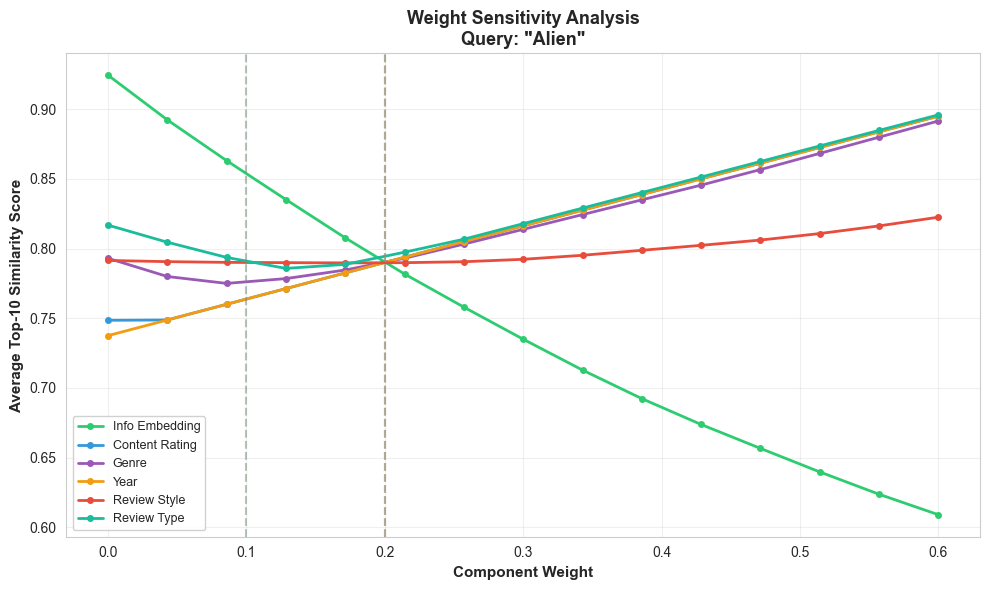

In [19]:
plot_weight_sensitivity(
    query_title="Alien",
    vectorized_data=vectorized_data,
    info_sim=info_sim,
    content_rating_sim=content_rating_sim,
    genre_sim=genre_sim,
    year_sim=year_sim,
    style_sim=style_sim,
    type_sim=type_sim,
    base_weights=(0.2, 0.2, 0.2, 0.2, 0.1, 0.1),
    top_k=10
)

## Similarity Matrix Heatmaps

Visualize how different similarity components measure relationships between movies.

Each heatmap shows similarity scores (0-1) for a sample of 20 movies.

In [20]:
def plot_similarity_heatmaps(info_sim, genre_sim, style_sim, type_sim, vectorized_data, sample_size=20):
    """
    Plot heatmaps of different similarity components
    """
    # Sample movies for visualization
    np.random.seed(42)
    sample_indices = np.random.choice(len(vectorized_data), size=min(sample_size, len(vectorized_data)), replace=False)
    sample_titles = [vectorized_data[i]['movie_title'][:30] for i in sample_indices]
    
    # Create figure with subplots
    fig, axes = plt.subplots(2, 2, figsize=(18, 16))
    fig.suptitle('Similarity Component Heatmaps', fontsize=18, fontweight='bold')
    
    # Extract sampled matrices
    matrices = [
        (info_sim[np.ix_(sample_indices, sample_indices)], 'Movie Info Similarity\n(Sentence Embeddings)', axes[0, 0]),
        (genre_sim[np.ix_(sample_indices, sample_indices)], 'Genre Similarity\n(Binary Vectors)', axes[0, 1]),
        (style_sim[np.ix_(sample_indices, sample_indices)], 'Review Style Similarity\n(Critic Writing Patterns)', axes[1, 0]),
        (type_sim[np.ix_(sample_indices, sample_indices)], 'Review Type Similarity\n(Fresh/Rotten Patterns)', axes[1, 1])
    ]
    
    for matrix, title, ax in matrices:
        sns.heatmap(matrix, 
                   xticklabels=sample_titles, 
                   yticklabels=sample_titles,
                   cmap='YlOrRd', 
                   vmin=0, 
                   vmax=1,
                   ax=ax,
                   cbar_kws={'label': 'Similarity Score'},
                   square=True)
        ax.set_title(title, fontweight='bold', fontsize=12, pad=10)
        ax.set_xlabel('')
        ax.set_ylabel('')
        plt.setp(ax.get_xticklabels(), rotation=45, ha='right', fontsize=8)
        plt.setp(ax.get_yticklabels(), rotation=0, fontsize=8)
    
    plt.tight_layout()
    return fig


### Generate Similarity Heatmaps

This creates a 2x2 grid showing similarity patterns across different components.

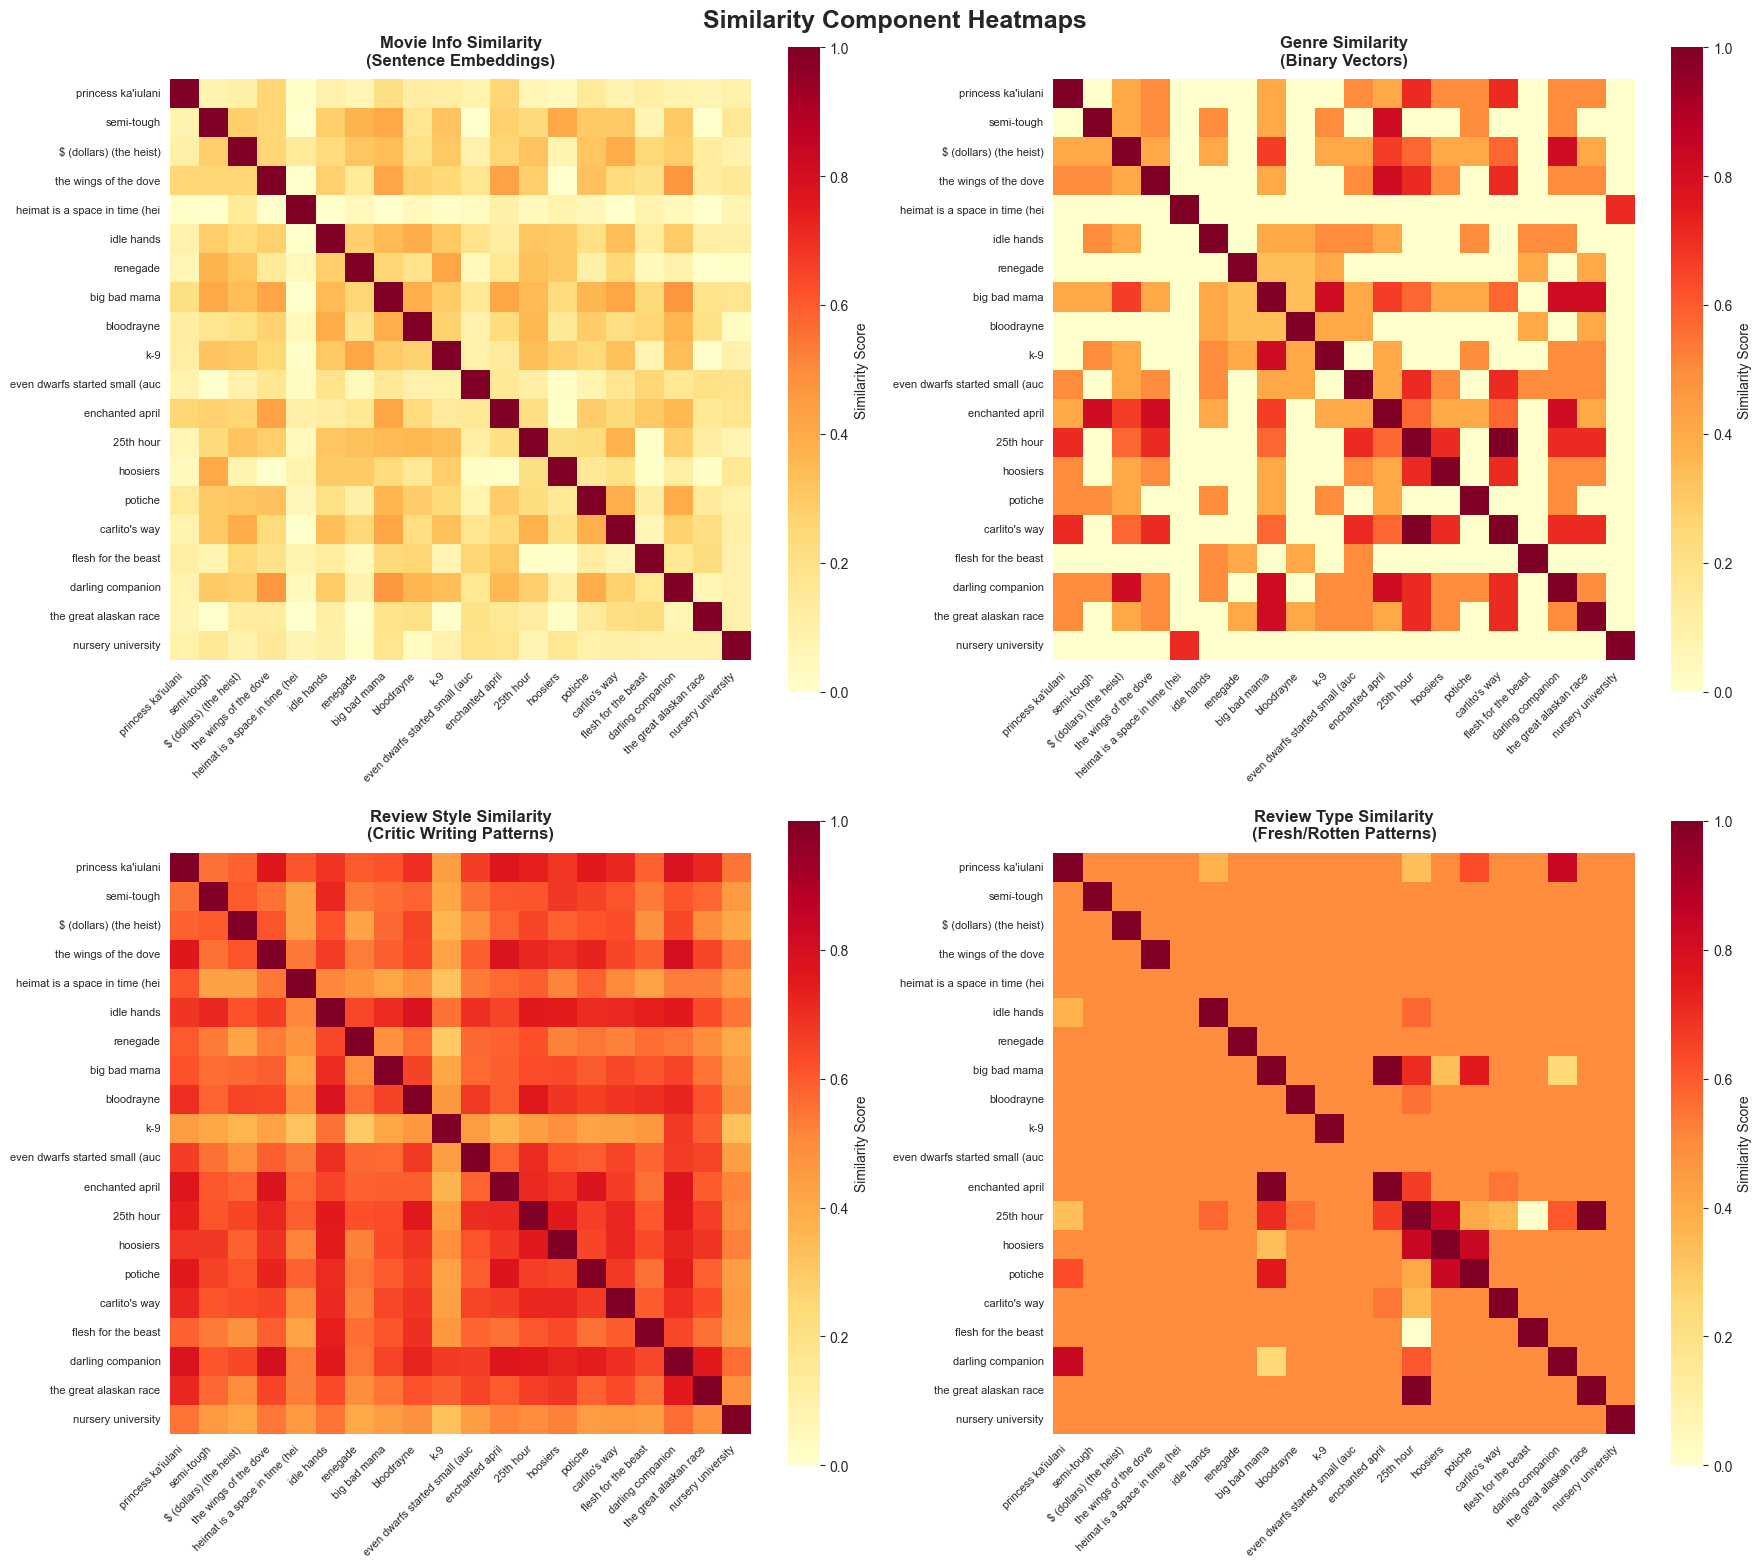

In [21]:
# Generate heatmaps for 20 randomly sampled movies
fig = plot_similarity_heatmaps(
    info_sim, 
    genre_sim, 
    style_sim, 
    type_sim, 
    vectorized_data, 
    sample_size=20
)
plt.show()


## Parameter Sensitivity Analysis

Test how different weight configurations affect recommendations.

Shows top 10 recommendations under 5 different weighting strategies.

In [22]:
def analyze_parameter_sensitivity(movie_title, vectorized_data,
                                 info_sim, content_rating_sim, genre_sim,
                                 year_sim, style_sim, type_sim):
    """
    Analyze how changing component weights affects recommendations.
    """
    # Find query movie
    query_idx = None
    for i, movie in enumerate(vectorized_data):
        if movie['movie_title'].lower() == movie_title.lower():
            query_idx = i
            break
    
    if query_idx is None:
        print(f"Movie '{movie_title}' not found!")
        return None
    
    # Test different weight configurations
    configs = {
        'Balanced': (0.2, 0.2, 0.2, 0.2, 0.1, 0.1),
        'Content-Heavy\n(Emphasis on embeddings)': (0.4, 0.2, 0.2, 0.05, 0.1, 0.05),
        'Genre-Heavy\n(Emphasis on genres)': (0.1, 0.1, 0.5, 0.1, 0.1, 0.1),
        'Style-Heavy\n(Emphasis on reviews)': (0.1, 0.1, 0.1, 0.1, 0.4, 0.2),
        'Temporal-Heavy\n(Emphasis on year)': (0.1, 0.1, 0.2, 0.4, 0.1, 0.1)
    }
    
    fig, axes = plt.subplots(2, 3, figsize=(20, 13))
    fig.suptitle(f'Parameter Sensitivity Analysis for "{movie_title}"\nTop 10 Recommendations Under Different Weight Configurations', 
                fontsize=16, fontweight='bold')
    axes = axes.flatten()
    
    all_recommendations = {}
    
    for idx, (config_name, (w1, w2, w3, w4, w5, w6)) in enumerate(configs.items()):
        # Compute hybrid similarity
        hybrid = (
            w1 * info_sim[query_idx] +
            w2 * content_rating_sim[query_idx] +
            w3 * genre_sim[query_idx] +
            w4 * year_sim[query_idx] +
            w5 * style_sim[query_idx] +
            w6 * type_sim[query_idx]
        )
        
        # Get top 10 recommendations
        sorted_indices = np.argsort(hybrid)[::-1]
        top_10 = [idx for idx in sorted_indices if idx != query_idx][:10]
        all_recommendations[config_name] = top_10
        
        # Visualize
        ax = axes[idx]
        movie_names = [vectorized_data[i]['movie_title'][:35] for i in top_10]
        scores = [hybrid[i] for i in top_10]
        
        colors_bar = plt.cm.viridis(np.linspace(0.3, 0.9, len(movie_names)))
        bars = ax.barh(range(len(movie_names)), scores, color=colors_bar, edgecolor='black', linewidth=0.5)
        
        ax.set_yticks(range(len(movie_names)))
        ax.set_yticklabels(movie_names, fontsize=9)
        ax.set_xlabel('Similarity Score', fontweight='bold', fontsize=10)
        ax.set_title(config_name, fontweight='bold', fontsize=11)
        ax.invert_yaxis()
        ax.grid(axis='x', alpha=0.3)
        
        # Add weight configuration
        weights_text = f'Info: {w1:.2f}\nCR: {w2:.2f}\nGenre: {w3:.2f}\nYear: {w4:.2f}\nStyle: {w5:.2f}\nType: {w6:.2f}'
        ax.text(0.98, 0.02, weights_text, transform=ax.transAxes,
               verticalalignment='bottom', horizontalalignment='right',
               bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8),
               fontsize=7, family='monospace')
        
        # Add score labels
        for bar, score in zip(bars, scores):
            width = bar.get_width()
            ax.text(width + 0.01, bar.get_y() + bar.get_height()/2,
                   f'{score:.3f}',
                   ha='left', va='center', fontsize=7, color='black')
    
    fig.delaxes(axes[-1])
    plt.tight_layout()
    
    # Print overlap statistics
    print("\n" + "="*80)
    print("RECOMMENDATION OVERLAP ANALYSIS")
    print("="*80)
    print("\nShowing how many movies appear in both recommendation lists:")
    print("-"*80)
    
    config_names = list(configs.keys())
    for i in range(len(config_names)):
        for j in range(i+1, len(config_names)):
            set1 = set(all_recommendations[config_names[i]])
            set2 = set(all_recommendations[config_names[j]])
            overlap = len(set1 & set2)
            percentage = (overlap / 10) * 100
            print(f"{config_names[i].split(chr(10))[0]:25} vs {config_names[j].split(chr(10))[0]:25} : {overlap:2}/10 ({percentage:5.1f}%)")
    
    print("\n" + "="*80)
    return fig


### Run Parameter Sensitivity Analysis

This tests 5 different weight configurations to see how they affect recommendations for a specific movie.


RECOMMENDATION OVERLAP ANALYSIS

Showing how many movies appear in both recommendation lists:
--------------------------------------------------------------------------------
Balanced                  vs Content-Heavy             :  9/10 ( 90.0%)
Balanced                  vs Genre-Heavy               :  7/10 ( 70.0%)
Balanced                  vs Style-Heavy               :  5/10 ( 50.0%)
Balanced                  vs Temporal-Heavy            :  8/10 ( 80.0%)
Content-Heavy             vs Genre-Heavy               :  6/10 ( 60.0%)
Content-Heavy             vs Style-Heavy               :  4/10 ( 40.0%)
Content-Heavy             vs Temporal-Heavy            :  7/10 ( 70.0%)
Genre-Heavy               vs Style-Heavy               :  4/10 ( 40.0%)
Genre-Heavy               vs Temporal-Heavy            :  9/10 ( 90.0%)
Style-Heavy               vs Temporal-Heavy            :  5/10 ( 50.0%)



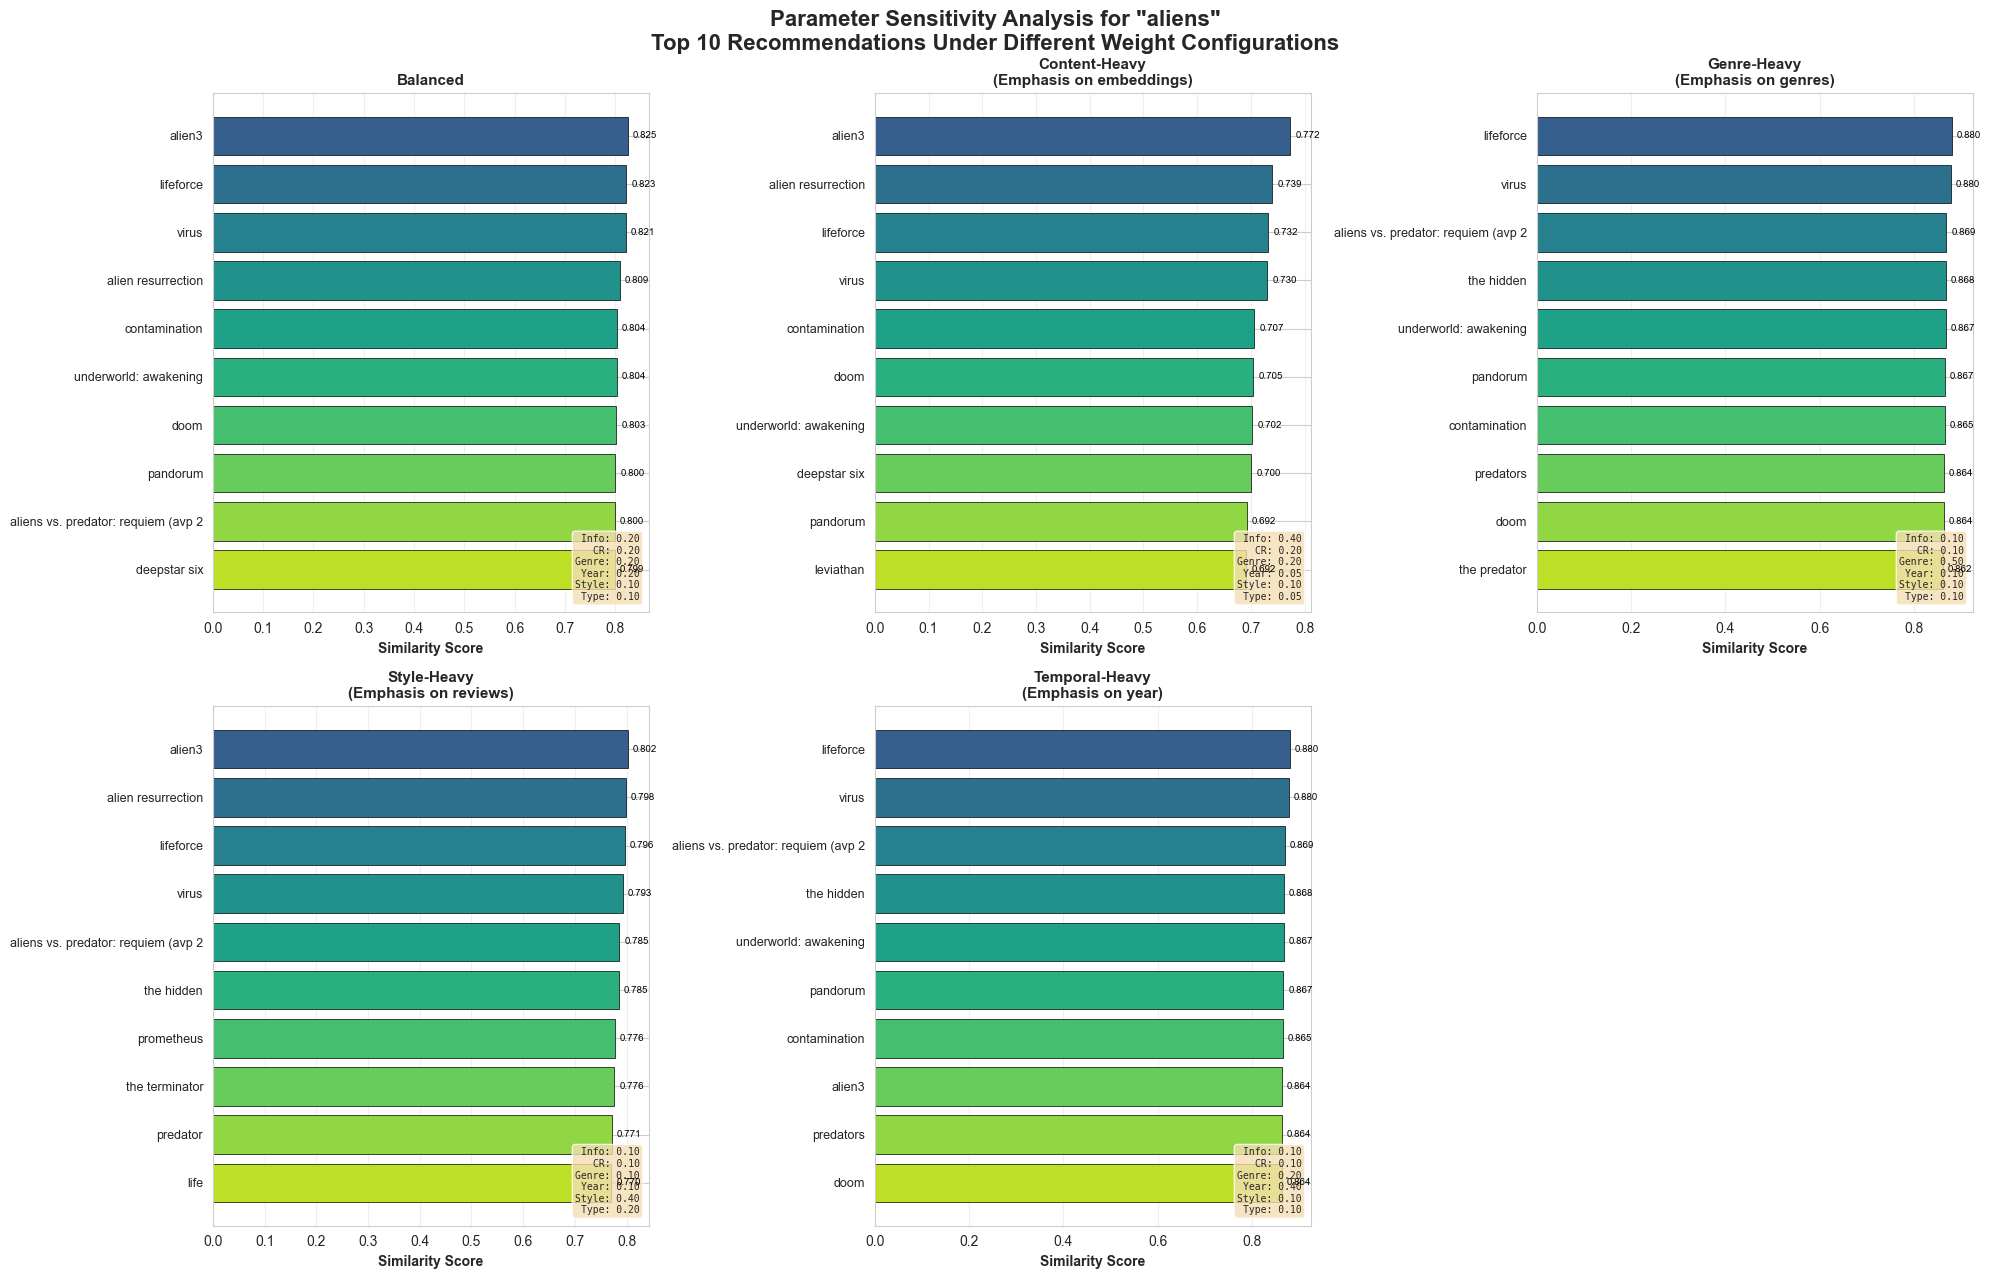

In [23]:
# Analyze parameter sensitivity for "Aliens"
fig = analyze_parameter_sensitivity(
    "aliens",
    vectorized_data,
    info_sim, 
    content_rating_sim, 
    genre_sim, 
    year_sim, 
    style_sim, 
    type_sim
)
if fig:
    plt.show()
